In [3]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from matplotlib_venn import venn3

In [4]:
SEED = 35

import random
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

INFO_PATH  = "selected_esg_scores.csv"
PRICE_PATH = "yahoo_all_stocks_10y_merged.csv"

FIG_DIR = "Figures"
os.makedirs(FIG_DIR, exist_ok=True)

k = 3  # assets per sector

weights = np.array([0.4, 0.35, 0.25])
weights /= weights.sum()

types = np.array([+1, +1, -1])  # ESG ↑, Return ↑, Vol ↓
vikor_v = 0.5


In [5]:
df_info = pd.read_csv(INFO_PATH)
df_price = pd.read_csv(PRICE_PATH)

df_price["Date"] = pd.to_datetime(df_price["Date"])
df_price = df_price.set_index("Date")

tickers = df_info["Ticker"].dropna().unique().tolist()
tickers = [t for t in tickers if t in df_price.columns]

df_price = df_price[tickers].astype(float)

df_return = np.log(df_price / df_price.shift(1)).dropna()
df_return = df_return[tickers]

df_info = df_info[df_info["Ticker"].isin(df_return.columns)].copy()

mu = df_return.mean() * 252
sigma = df_return.std() * np.sqrt(252)

df_all = df_info.merge(
    pd.DataFrame({
        "Ticker": df_return.columns,
        "Return": mu.values,
        "Volatility": sigma.values
    }),
    on="Ticker"
)


In [6]:
CRIT_COLS = ["ESG_Score", "Return", "Volatility"]

def normalize(df, types):
    out = df.copy()
    for col, t in zip(out.columns, types):
        mn, mx = out[col].min(), out[col].max()
        if t == 1:
            out[col] = (out[col] - mn) / (mx - mn + 1e-12)
        else:
            out[col] = (mx - out[col]) / (mx - mn + 1e-12)
    return out


In [7]:
def ahp_score(df):
    return normalize(df[CRIT_COLS], types).values @ weights

def topsis_score(df):
    Z = normalize(df[CRIT_COLS], types).values
    V = Z * weights
    d_plus = np.linalg.norm(V - V.max(axis=0), axis=1)
    d_minus = np.linalg.norm(V - V.min(axis=0), axis=1)
    return d_minus / (d_plus + d_minus + 1e-12)

def vikor_score(df, v=0.5):
    crit = df[CRIT_COLS].values
    f_star = np.where(types == 1, crit.max(axis=0), crit.min(axis=0))
    f_minus = np.where(types == 1, crit.min(axis=0), crit.max(axis=0))
    denom = f_star - f_minus + 1e-12

    S = ((weights * (f_star - crit) / denom)).sum(axis=1)
    R = ((weights * (f_star - crit) / denom)).max(axis=1)

    Q = (
        v * (S - S.min()) / (S.max() - S.min() + 1e-12) +
        (1 - v) * (R - R.min()) / (R.max() - R.min() + 1e-12)
    )
    return Q


In [8]:
def select_top_k(df, score_col, higher=True):
    asc = not higher
    return (
        df.sort_values(score_col, ascending=asc)
          .groupby("Category", group_keys=False)
          .head(k)
          .copy()
    )


In [9]:
df_ahp = df_all.copy()
df_ahp["score"] = ahp_score(df_ahp)
df_ahp_sel = select_top_k(df_ahp, "score", True)

df_topsis = df_all.copy()
df_topsis["score"] = topsis_score(df_topsis)
df_topsis_sel = select_top_k(df_topsis, "score", True)

df_vikor = df_all.copy()
df_vikor["score"] = vikor_score(df_vikor, vikor_v)
df_vikor_sel = select_top_k(df_vikor, "score", False)

selected_sets = {
    "AHP": set(df_ahp_sel["Ticker"]),
    "TOPSIS": set(df_topsis_sel["Ticker"]),
    "VIKOR": set(df_vikor_sel["Ticker"])
}


In [10]:
def build_markowitz(df_sel, df_return):
    # ---------------------------
    # 1. Mean–variance inputs
    # ---------------------------
    tickers = df_sel["Ticker"].tolist()
    mu_sel = df_return[tickers].mean() * 252
    Sigma = df_return[tickers].cov().values * 252
    Sigma = 0.5 * (Sigma + Sigma.T) + np.eye(len(tickers)) * 1e-6

    mu = mu_sel.values
    n = len(mu)

    # ---------------------------
    # 2. Numerical (QP) frontier
    # ---------------------------
    w = cp.Variable(n)
    tr = cp.Parameter()

    prob = cp.Problem(
        cp.Minimize(cp.quad_form(w, Sigma)),
        [
            cp.sum(w) == 1,
            w @ mu == tr,
            w >= 1e-4
        ]
    )

    frontier = []
    for r in np.linspace(mu.min(), mu.max(), 100):
        tr.value = r
        try:
            prob.solve(solver=cp.OSQP, warm_start=True)
            if prob.status == cp.OPTIMAL and w.value is not None:
                wv = w.value
                var = wv @ Sigma @ wv
                frontier.append({
                    "stdev": np.sqrt(var),
                    "return": wv @ mu,
                    "weights": wv
                })
        except:
            pass

    frontier_df = pd.DataFrame(frontier)

    # ---------------------------
    # 4. Global random portfolios
    # ---------------------------
    num_port_global = 100_000
    alpha = 0.0005

    weights_global = np.random.dirichlet(
        np.full(n, alpha),
        num_port_global
    )

    ret_1 = weights_global @ mu
    var_1 = np.einsum("ij,jk,ik->i", weights_global, Sigma, weights_global)

    port_df_1 = pd.DataFrame({
        "Volatility": np.sqrt(var_1),
        "Return": ret_1
    })

    # ---------------------------
    # 5. Frontier-focused sampling
    # ---------------------------
    port_df_2 = pd.DataFrame(columns=["Volatility", "Return"])

    if len(frontier_df) >= 2:
        W_front = np.vstack(frontier_df["weights"].values)
        eps = 1e-7

        num_port_strat = 5_000
        n_bins = len(W_front)
        n_per_bin = max(1, num_port_strat // n_bins)

        kappa_vals = np.geomspace(1, 1e5, 20)
        kappa_wts = 1.0 / (kappa_vals + 1e-12)
        kappa_wts /= kappa_wts.sum()

        weights_list = []

        for i in range(n_bins):
            sizes = np.floor(n_per_bin * kappa_wts).astype(int)
            sizes[:max(0, n_per_bin - sizes.sum())] += 1

            for kappa, sz in zip(kappa_vals, sizes):
                if sz > 0:
                    alphas_i = kappa * (W_front[i] + eps)
                    weights_list.append(np.random.dirichlet(alphas_i, sz))

        if len(weights_list) > 0:
            weights_strat = np.vstack(weights_list)
            ret_2 = weights_strat @ mu
            var_2 = np.einsum("ij,jk,ik->i", weights_strat, Sigma, weights_strat)

            port_df_2 = pd.DataFrame({
                "Volatility": np.sqrt(var_2),
                "Return": ret_2
            })

    # ---------------------------
    # 6. Combine portfolios
    # ---------------------------
    port_df = pd.concat([port_df_1, port_df_2], ignore_index=True)

    return {
        "frontier": frontier_df,
        "portfolios": port_df,
        "mu_sel": mu_sel,
        "df_return_sel": df_return[tickers],
    }


In [11]:
results = {}

for name, df_sel in zip(
    ["AHP", "TOPSIS", "VIKOR"],
    [df_ahp_sel, df_topsis_sel, df_vikor_sel]
):
    res = build_markowitz(df_sel, df_return)

    results[name] = res


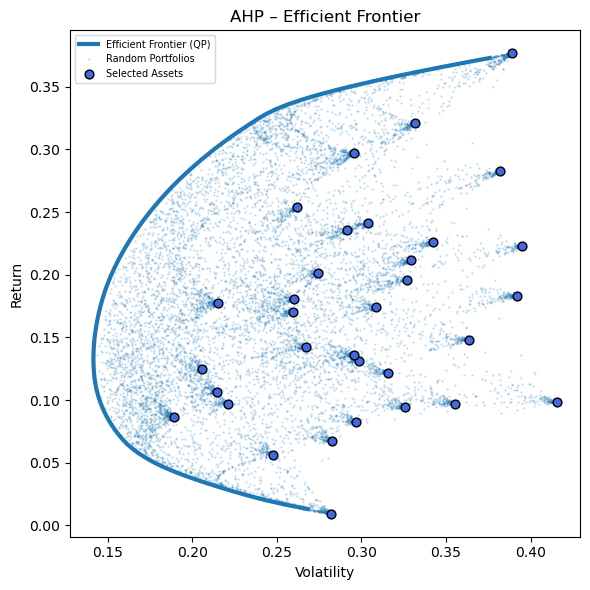

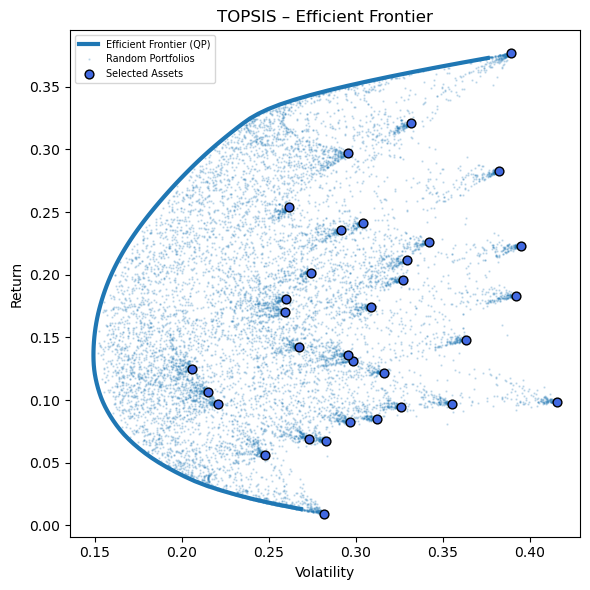

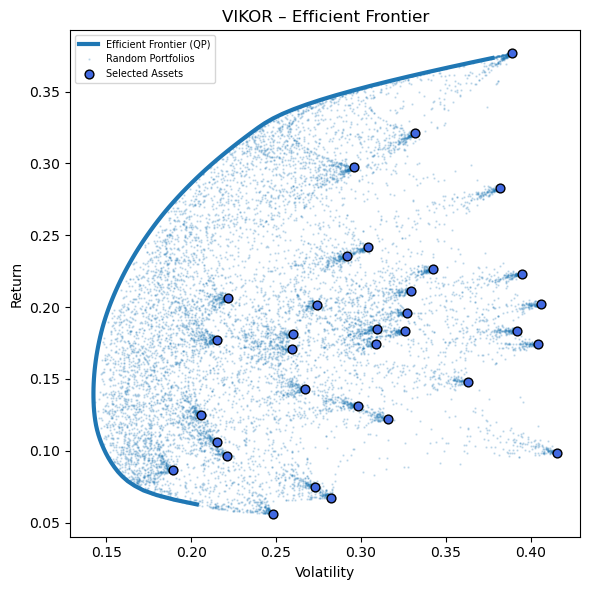

In [12]:
for name, res in results.items():
    fig, ax = plt.subplots(figsize=(6, 6))

    # Numerical frontier
    if not res["frontier"].empty:
        ax.plot(
            res["frontier"]["stdev"],
            res["frontier"]["return"],
            lw=3,
            label="Efficient Frontier (QP)"
        )

    # Random + stratified portfolios
    ax.scatter(
        res["portfolios"]["Volatility"],
        res["portfolios"]["Return"],
        s=0.5,
        alpha=0.2,
        label="Random Portfolios"
    )

    # Selected assets
    asset_std = res["df_return_sel"].std() * np.sqrt(252)
    ax.scatter(
        asset_std,
        res["mu_sel"].values,
        s=40,
        facecolors='royalblue',
        edgecolors="k",
        label="Selected Assets"
    )

    ax.set_title(f"{name} – Efficient Frontier")
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    ax.legend(fontsize=7)
    fig.tight_layout()

    fig.savefig(f"{FIG_DIR}/{name}_Frontier.png", dpi=200)
    plt.show()
    plt.close(fig)


/opt/anaconda3/lib/python3.12/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


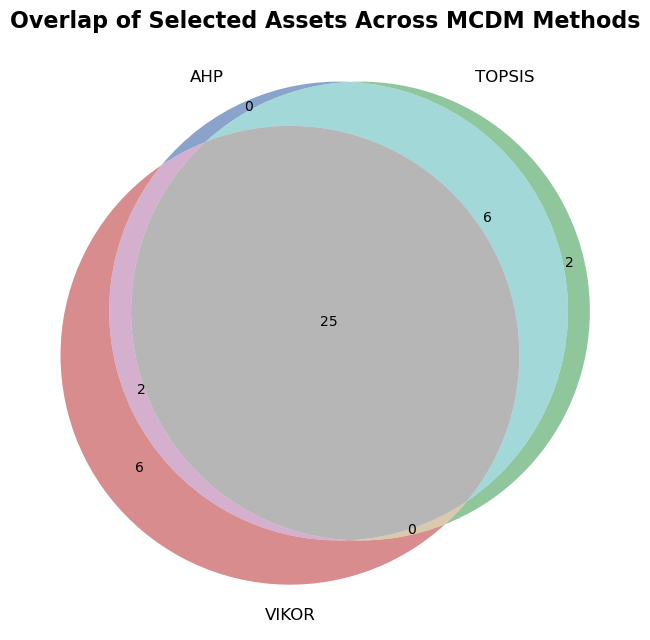

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

venn3(
    [selected_sets["AHP"], selected_sets["TOPSIS"], selected_sets["VIKOR"]],
    set_labels=("AHP", "TOPSIS", "VIKOR"),
    set_colors=("#4C72B0", "#55A868", "#C44E52"),  # blue / green / red
    alpha=0.65,
    ax=ax
)

ax.set_title(
    "Overlap of Selected Assets Across MCDM Methods",
    fontsize=16,
    fontweight="bold"
)

fig.savefig(f"{FIG_DIR}/Venn_SelectedAssets.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)


In [14]:
def build_esg_frontier(
    mu_sel,
    df_cov_sel,
    df_info_sel,
    max_w_per_asset=0.20,
    min_sector_weight=0.02,
    delta_esg=0.0,
    n_grid=30
):
    """
    Builds an ESG-constrained efficient frontier
    """

    # ---------------------------
    # Inputs
    # ---------------------------
    mu_np = mu_sel.values
    Sigma_np = df_cov_sel.values * 252
    Sigma_np = 0.5 * (Sigma_np + Sigma_np.T)

    esg_np = df_info_sel["ESG_Score"].values
    sectors = df_info_sel["Category"].tolist()
    unique_sectors = sorted(set(sectors))
    n_assets = len(mu_np)

    # ---------------------------
    # Sector masks
    # ---------------------------
    sector_masks = [
        np.array([1 if s == sec else 0 for s in sectors])
        for sec in unique_sectors
    ]

    # ---------------------------
    # ESG parameters
    # ---------------------------
    esg_bar = esg_np.mean()
    grid = np.linspace(mu_np.min(), mu_np.max() * 0.95, n_grid)

    frontier_esg = []

    # ---------------------------
    # Optimization loop
    # ---------------------------
    for tr in tqdm(grid, desc="Building ESG frontier"):

        w = cp.Variable(n_assets)
        risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            w <= max_w_per_asset,
            mu_np @ w >= tr,
            esg_np @ w >= esg_bar + delta_esg
        ]

        # minimum sector exposure
        for mask in sector_masks:
            constraints.append(mask @ w >= min_sector_weight)

        prob = cp.Problem(cp.Minimize(risk), constraints)

        try:
            prob.solve(solver=cp.OSQP, warm_start=True)

            if prob.status == cp.OPTIMAL and w.value is not None:
                w_val = np.array(w.value).flatten()
                var = float(w_val @ Sigma_np @ w_val)

                frontier_esg.append({
                    "target_return": tr,
                    "achieved_return": float(mu_np @ w_val),
                    "variance": var,
                    "stdev": np.sqrt(var),
                    "weights": w_val
                })
        except Exception:
            continue
            
    frontier_esg_df = pd.DataFrame(frontier_esg)

    frontier_esg_df = (
        frontier_esg_df
        .dropna()
        .sort_values("achieved_return")
        .reset_index(drop=True)
    )
    
    return frontier_esg_df


In [15]:
for name, df_sel in zip(
    ["AHP", "TOPSIS", "VIKOR"],
    [df_ahp_sel, df_topsis_sel, df_vikor_sel]
):
    res = build_markowitz(df_sel, df_return)

    # Build ESG frontier for THIS method universe
    frontier_esg_df = build_esg_frontier(
        mu_sel=res["mu_sel"],
        df_cov_sel=df_return[res["df_return_sel"].columns].cov(),
        df_info_sel=df_sel,
        max_w_per_asset=0.20,
        min_sector_weight=0.02,
        delta_esg=0.0
    )

    res["frontier_esg"] = frontier_esg_df
    results[name] = res


Building ESG frontier: 100%|████████████████████| 30/30 [00:00<00:00, 95.44it/s]


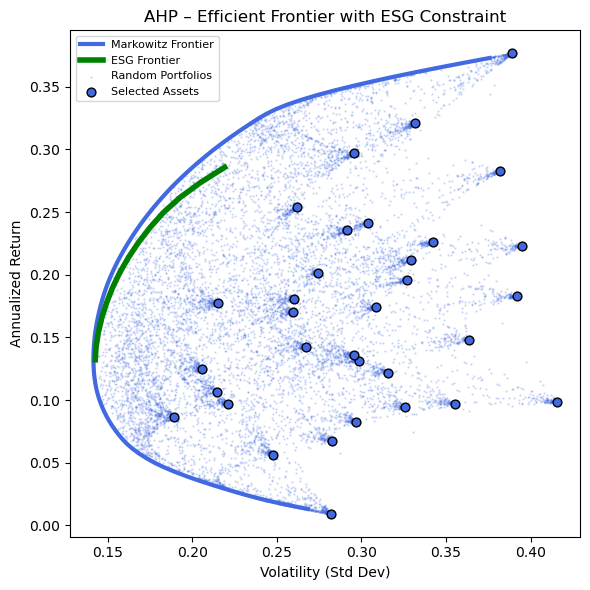

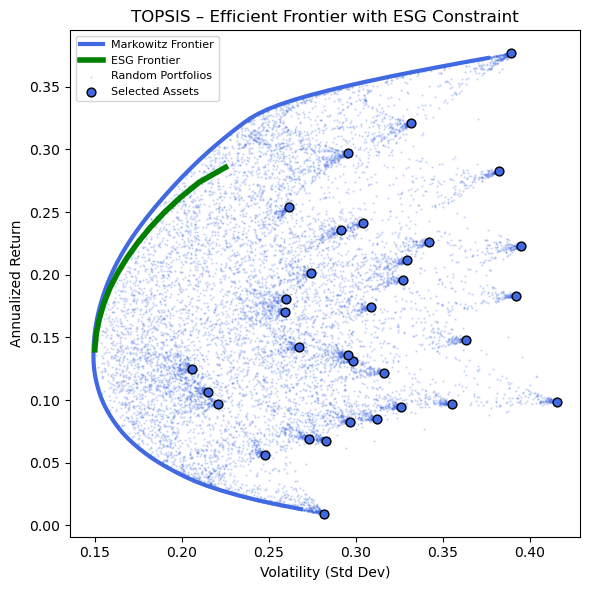

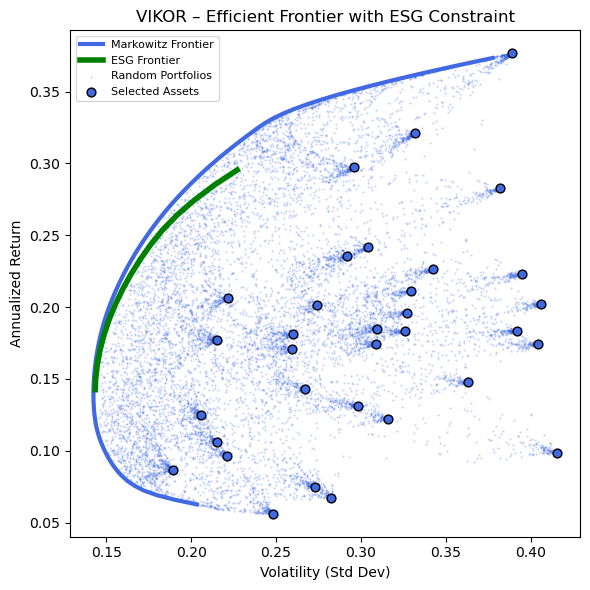

In [16]:
for method, res in results.items():

    frontier_df = res["frontier"]
    frontier_esg_df = res["frontier_esg"]
    port_df = res["portfolios"]

    mu_sel = res["mu_sel"]
    df_return_sel = res["df_return_sel"]

    asset_returns = mu_sel.values
    asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

    plt.figure(figsize=(6, 6))

    # -------------------------------
    # Classical (Markowitz) frontier
    # -------------------------------
    plt.plot(
        frontier_df["stdev"],
        frontier_df["return"],
        color="royalblue",
        linewidth=3,
        label="Markowitz Frontier"
    )

    # -------------------------------
    # ESG (Green) frontier – continuous
    # -------------------------------
    plt.plot(
        frontier_esg_df["stdev"],
        frontier_esg_df["achieved_return"],
        color="green",
        linewidth=4,
        linestyle="-",
        label="ESG Frontier"
    )

    # -------------------------------
    # Random portfolios
    # -------------------------------
    plt.scatter(
        port_df["Volatility"],
        port_df["Return"],
        s=0.5,
        facecolors="royalblue",
        alpha=0.2,
        label="Random Portfolios"
    )

    # -------------------------------
    # Selected assets
    # -------------------------------
    plt.scatter(
        asset_stdevs,
        asset_returns,
        facecolors="royalblue",
        edgecolors="k",
        linewidths=1,
        s=40,
        label="Selected Assets"
    )

    plt.legend(loc="best", fontsize=8)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Annualized Return")
    plt.title(f"{method} – Efficient Frontier with ESG Constraint")

    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{method}_Frontier_ESG.png", dpi=144, transparent=True)
    plt.show()
    plt.close()


In [33]:
def build_brown_frontier(
    mu_sel,
    df_cov_sel,
    df_info_sel,
    max_w_per_asset=0.20,
    min_sector_weight=0.02,
    delta_esg=0.0,
    n_grid=30
):
    """
    Builds a low-ESG (Brown) efficient frontier,
    symmetric to the Green frontier.
    """

    # ---------------------------
    # Inputs
    # ---------------------------
    mu_np = mu_sel.values
    Sigma_np = df_cov_sel.values * 252
    Sigma_np = 0.5 * (Sigma_np + Sigma_np.T)

    esg_np = df_info_sel["ESG_Score"].values
    sectors = df_info_sel["Category"].tolist()
    unique_sectors = sorted(set(sectors))
    n_assets = len(mu_np)

    # ---------------------------
    # Sector masks
    # ---------------------------
    sector_masks = [
        np.array([1 if s == sec else 0 for s in sectors])
        for sec in unique_sectors
    ]

    # ---------------------------
    # ESG parameters
    # ---------------------------
    esg_bar = esg_np.mean()
    grid = np.linspace(mu_np.min(), mu_np.max() * 0.95, n_grid)

    frontier_brown = []

    # ---------------------------
    # Optimization loop
    # ---------------------------
    for tr in tqdm(grid, desc="Building Brown frontier"):

        w = cp.Variable(n_assets)
        risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            w <= max_w_per_asset,
            mu_np @ w >= tr,
            esg_np @ w <= esg_bar - delta_esg
        ]

        # same sector rule as Green
        for mask in sector_masks:
            constraints.append(mask @ w >= min_sector_weight)

        prob = cp.Problem(cp.Minimize(risk), constraints)

        try:
            prob.solve(solver=cp.OSQP, warm_start=True)

            if prob.status == cp.OPTIMAL and w.value is not None:
                w_val = np.array(w.value).flatten()
                var = float(w_val @ Sigma_np @ w_val)

                frontier_brown.append({
                    "target_return": tr,
                    "achieved_return": float(mu_np @ w_val),
                    "variance": var,
                    "stdev": np.sqrt(var),
                    "weights": w_val
                })
        except Exception:
            continue

    frontier_brown_df = pd.DataFrame(frontier_brown)

    # ---------------------------
    # Clean & order (IMPORTANT)
    # ---------------------------
    frontier_brown_df = (
        frontier_brown_df
        .dropna()
        .sort_values("achieved_return")
        .reset_index(drop=True)
    )

    return frontier_brown_df


In [35]:
for name, df_sel in zip(
    ["AHP", "TOPSIS", "VIKOR"],
    [df_ahp_sel, df_topsis_sel, df_vikor_sel]
):
    res = build_markowitz(df_sel, df_return)

    # --- Green frontier ---
    res["frontier_esg"] = build_esg_frontier(
        mu_sel=res["mu_sel"],
        df_cov_sel=df_return[res["df_return_sel"].columns].cov(),
        df_info_sel=df_sel,
        max_w_per_asset=0.20,
        min_sector_weight=0.02,
        delta_esg=0.0
    )

    # --- Brown frontier ---
    res["frontier_brown"] = build_brown_frontier(
        mu_sel=res["mu_sel"],
        df_cov_sel=df_return[res["df_return_sel"].columns].cov(),
        df_info_sel=df_sel,
        max_w_per_asset=0.20,
        min_sector_weight=0.02,
        delta_esg=0.0
    )

    results[name] = res


Building Brown frontier: 100%|█████████████████| 30/30 [00:00<00:00, 127.36it/s]


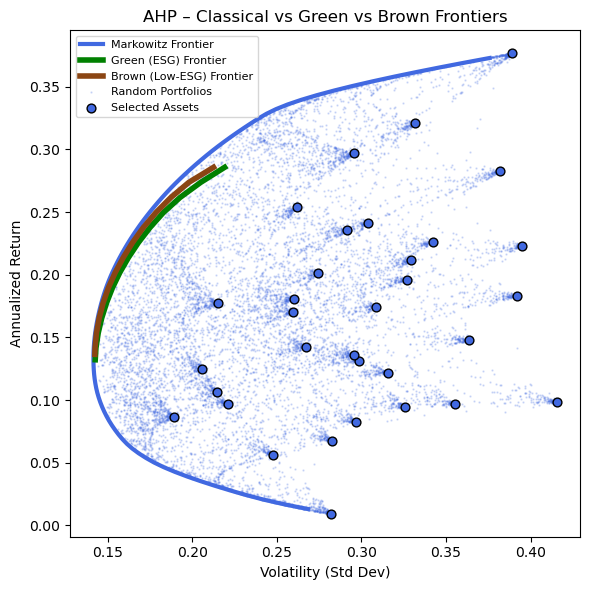

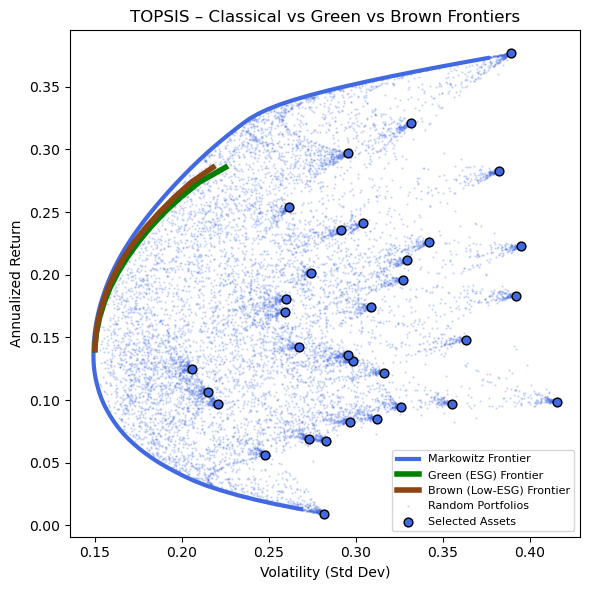

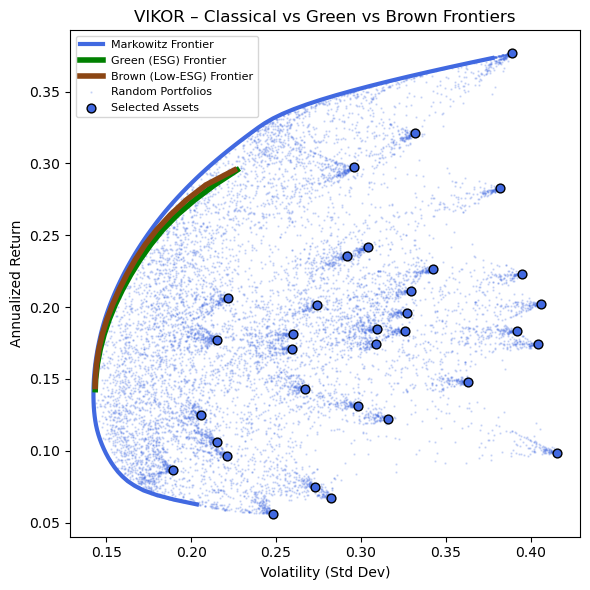

In [36]:
for method, res in results.items():

    frontier_df = res["frontier"]
    frontier_esg_df = res["frontier_esg"]
    frontier_brown_df = res["frontier_brown"]
    port_df = res["portfolios"]

    mu_sel = res["mu_sel"]
    df_return_sel = res["df_return_sel"]

    asset_returns = mu_sel.values
    asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

    plt.figure(figsize=(6, 6))

    # -------------------------------
    # Classical (Markowitz) frontier
    # -------------------------------
    plt.plot(
        frontier_df["stdev"],
        frontier_df["return"],
        color="royalblue",
        linewidth=3,
        label="Markowitz Frontier"
    )

    # -------------------------------
    # Green (ESG) frontier
    # -------------------------------
    plt.plot(
        frontier_esg_df["stdev"],
        frontier_esg_df["achieved_return"],
        color="green",
        linewidth=4,
        label="Green (ESG) Frontier"
    )

    # -------------------------------
    # Brown (Low-ESG) frontier
    # -------------------------------
    plt.plot(
        frontier_brown_df["stdev"],
        frontier_brown_df["achieved_return"],
        color="saddlebrown",
        linewidth=4,
        label="Brown (Low-ESG) Frontier"
    )

    # -------------------------------
    # Random portfolios
    # -------------------------------
    plt.scatter(
        port_df["Volatility"],
        port_df["Return"],
        s=0.5,
        alpha=0.2,
        color="royalblue",
        label="Random Portfolios"
    )

    # -------------------------------
    # Selected assets
    # -------------------------------
    plt.scatter(
        asset_stdevs,
        asset_returns,
        facecolors="royalblue",
        edgecolors="k",
        linewidths=1,
        s=40,
        label="Selected Assets"
    )

    plt.legend(loc="best", fontsize=8)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Annualized Return")
    plt.title(f"{method} – Classical vs Green vs Brown Frontiers")

    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{method}_Frontier_Comparison.png",
                dpi=144, transparent=True)
    plt.show()
    plt.close()


In [37]:
def compute_benchmarks(mu_sel, df_return_sel):
    """
    Compute standard benchmark portfolios:
    - Equal-weight (EW)
    - Inverse-volatility-weighted (IVW)
    """

    n_assets = len(mu_sel)

    # ---------------------------
    # Equal-weight portfolio
    # ---------------------------
    w_ew = np.ones(n_assets) / n_assets
    ret_ew = float(mu_sel.values @ w_ew)
    vol_ew = float(
        np.sqrt(
            w_ew @ (df_return_sel.cov().values * 252) @ w_ew
        )
    )

    # ---------------------------
    # Inverse-volatility portfolio
    # ---------------------------
    asset_vols = df_return_sel.std(axis=0).values * np.sqrt(252)
    inv_vol = 1.0 / asset_vols
    w_ivw = inv_vol / inv_vol.sum()

    ret_ivw = float(mu_sel.values @ w_ivw)
    vol_ivw = float(
        np.sqrt(
            w_ivw @ (df_return_sel.cov().values * 252) @ w_ivw
        )
    )

    return {
        "EW": {
            "weights": w_ew,
            "return": ret_ew,
            "volatility": vol_ew
        },
        "IVW": {
            "weights": w_ivw,
            "return": ret_ivw,
            "volatility": vol_ivw
        }
    }


In [38]:
for method, res in results.items():

    benchmarks = compute_benchmarks(
        mu_sel=res["mu_sel"],
        df_return_sel=res["df_return_sel"]
    )

    res["benchmarks"] = benchmarks


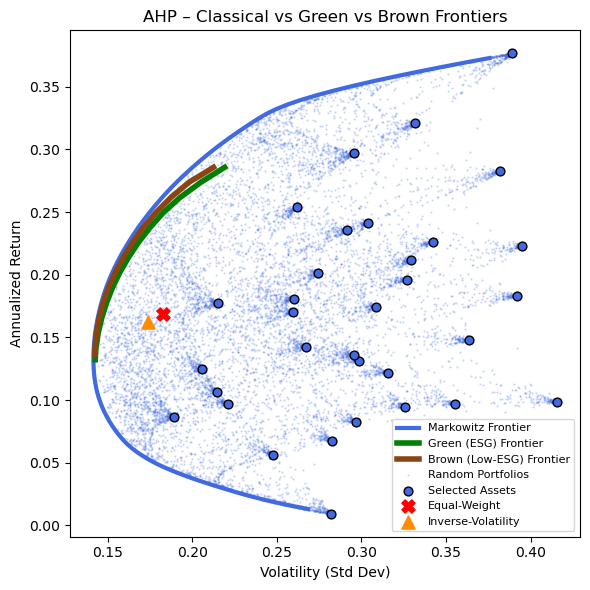

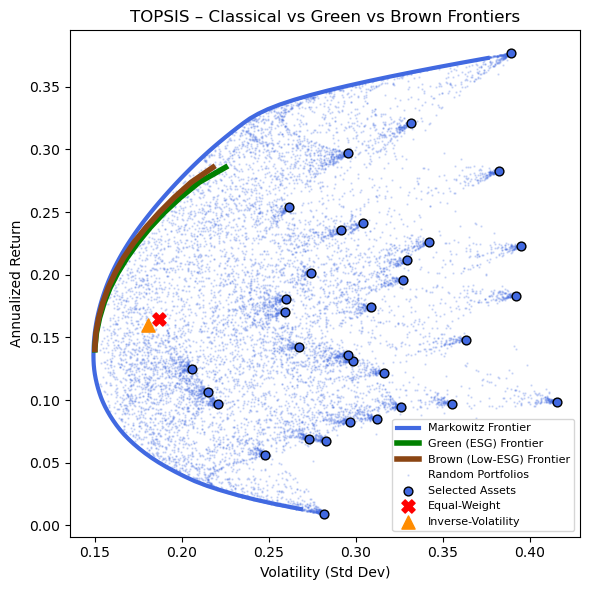

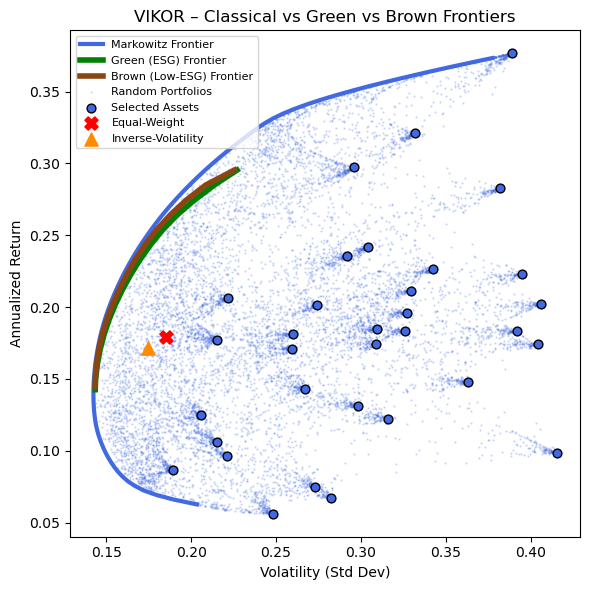

In [39]:
for method, res in results.items():

    frontier_df = res["frontier"]
    frontier_esg_df = res["frontier_esg"]
    frontier_brown_df = res["frontier_brown"]
    port_df = res["portfolios"]
    bench = res["benchmarks"]

    mu_sel = res["mu_sel"]
    df_return_sel = res["df_return_sel"]

    asset_returns = mu_sel.values
    asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

    plt.figure(figsize=(6, 6))

    # -------------------------------
    # Classical (Markowitz) frontier
    # -------------------------------
    plt.plot(
        frontier_df["stdev"],
        frontier_df["return"],
        color="royalblue",
        linewidth=3,
        label="Markowitz Frontier"
    )

    # -------------------------------
    # Green (ESG) frontier
    # -------------------------------
    plt.plot(
        frontier_esg_df["stdev"],
        frontier_esg_df["achieved_return"],
        color="green",
        linewidth=4,
        label="Green (ESG) Frontier"
    )

    # -------------------------------
    # Brown (Low-ESG) frontier
    # -------------------------------
    plt.plot(
        frontier_brown_df["stdev"],
        frontier_brown_df["achieved_return"],
        color="saddlebrown",
        linewidth=4,
        label="Brown (Low-ESG) Frontier"
    )

    # -------------------------------
    # Random portfolios
    # -------------------------------
    plt.scatter(
        port_df["Volatility"],
        port_df["Return"],
        s=0.5,
        alpha=0.2,
        color="royalblue",
        label="Random Portfolios"
    )

    # -------------------------------
    # Selected assets
    # -------------------------------
    plt.scatter(
        asset_stdevs,
        asset_returns,
        facecolors="royalblue",
        edgecolors="k",
        linewidths=1,
        s=40,
        label="Selected Assets"
    )
    # Equal-weight benchmark
    plt.scatter(
        bench["EW"]["volatility"],
        bench["EW"]["return"],
        marker="X",
        s=90,
        color="red",
        label="Equal-Weight"
    )
    
    # Inverse-volatility benchmark
    plt.scatter(
        bench["IVW"]["volatility"],
        bench["IVW"]["return"],
        marker="^",
        s=90,
        color="darkorange",
        label="Inverse-Volatility"
)

    plt.legend(loc="best", fontsize=8)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Annualized Return")
    plt.title(f"{method} – Classical vs Green vs Brown Frontiers")

    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{method}_Frontier_Comparison.png",
                dpi=144, transparent=True)
    plt.show()
    plt.close()


In [40]:
# ============================================================
# TANGENCY PORTFOLIOS (MAXIMUM SHARPE RATIO)
# ============================================================

rf = 0.00012 * 252  # annualized risk-free rate

def compute_tangency(frontier_df, rf):
    """
    Compute tangency portfolio from a frontier DataFrame
    (maximum Sharpe ratio).
    """
    if frontier_df is None or frontier_df.empty:
        return None

    df = frontier_df.copy()

    # unify naming
    if "achieved_return" in df.columns:
        ret_col = "achieved_return"
    else:
        ret_col = "return"

    df["stdev"] = pd.to_numeric(df["stdev"], errors="coerce")
    df[ret_col] = pd.to_numeric(df[ret_col], errors="coerce")

    df["sharpe"] = (df[ret_col] - rf) / df["stdev"]
    df = df[np.isfinite(df["sharpe"])]

    if df.empty:
        return None

    idx = df["sharpe"].idxmax()

    return {
        "weights": np.array(df.loc[idx, "weights"]).flatten(),
        "return": float(df.loc[idx, ret_col]),
        "volatility": float(df.loc[idx, "stdev"]),
        "sharpe": float(df.loc[idx, "sharpe"])
    }


In [41]:
for method, res in results.items():

    res["tangency"] = {
        "classical": compute_tangency(res["frontier"], rf),
        "green": compute_tangency(res["frontier_esg"], rf),
        "brown": compute_tangency(res["frontier_brown"], rf)
    }


In [42]:
for method, res in results.items():

    out_dir = f"{FIG_DIR}/{method}/Tangency"
    os.makedirs(out_dir, exist_ok=True)

    asset_cols = res["df_return_sel"].columns.tolist()

    for key in ["classical", "green", "brown"]:
        t = res["tangency"][key]
        if t is None:
            continue

        pd.DataFrame({
            "asset": asset_cols,
            "weight": t["weights"]
        }).to_csv(
            f"{out_dir}/tangency_{key}_weights.csv",
            index=False
        )


In [43]:
rows = []

for method, res in results.items():
    for key, label in [
        ("classical", "Markowitz"),
        ("green", "Green"),
        ("brown", "Brown")
    ]:
        t = res["tangency"][key]
        if t is not None:
            rows.append({
                "Method": method,
                "Frontier": label,
                "rf": rf,
                "Return": t["return"],
                "Volatility": t["volatility"],
                "Sharpe": t["sharpe"]
            })

tangency_summary = pd.DataFrame(rows)
tangency_summary.to_csv(f"{FIG_DIR}/Tangency_Summary.csv", index=False)


In [44]:
def plot_frontier(
    title,
    filename,
    frontiers,
    mc_df,
    asset_returns,
    asset_stdevs,
    rf,
    tangencies,
    benchmarks=None,
    xlim=None,
    ylim=None,
    figsize=(6, 6)
):
    plt.figure(figsize=figsize)

    # Frontiers
    for f in frontiers:
        plt.plot(
            f["stdev"],
            f["achieved_return"],
            linewidth=f.get("lw", 3),
            color=f["color"],
            label=f["label"]
        )

    # Monte Carlo portfolios
    plt.scatter(
        mc_df["Volatility"], mc_df["Return"],
        s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios"
    )

    # Individual assets
    plt.scatter(
        asset_stdevs, asset_returns,
        facecolors='royalblue', edgecolors='k',
        linewidths=1, s=40, label="Assets"
    )

    # Tangency portfolios and CALs
    for t in tangencies:
        plt.scatter(
            t["vol"], t["ret"],
            c=t["color"], edgecolors='k', marker='*',
            s=t.get("size", 250), linewidths=2.5, label=t["label"]
        )
        plt.plot(
            [0, t["vol"]],
            [rf, t["ret"]],
            linestyle='--', color='gray', linewidth=2.5,
            label=f'CAL ({t["label"]})'
        )

    # Benchmarks
    if benchmarks:
        for b in benchmarks:
            plt.scatter(
                b["vol"], b["ret"],
                c=b["color"], marker=b["marker"],
                s=b["s"], label=b["label"]
            )

    # Risk-free asset
    plt.scatter(
        0, rf, facecolors='none', edgecolors='k',
        s=40, linewidths=2, label='Risk-Free Asset'
    )

    plt.title(title)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Return")
    plt.grid(False)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.legend(loc='lower right', fontsize=8)
    plt.savefig(f"AHP/{filename}", dpi=144, transparent=True)
    plt.show()


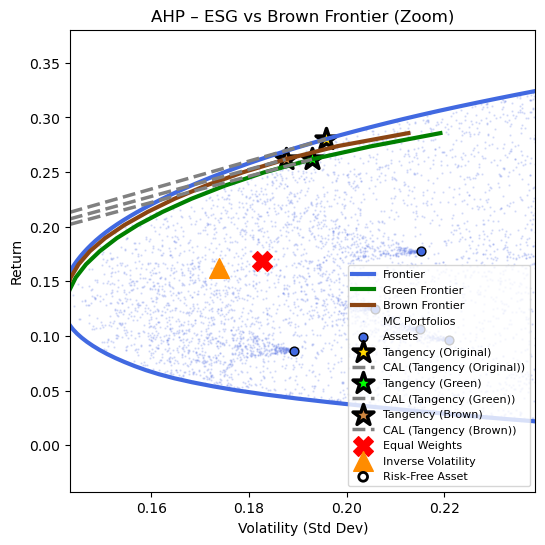

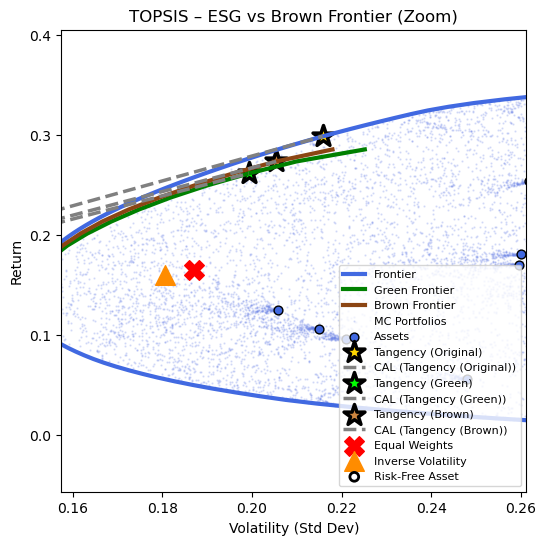

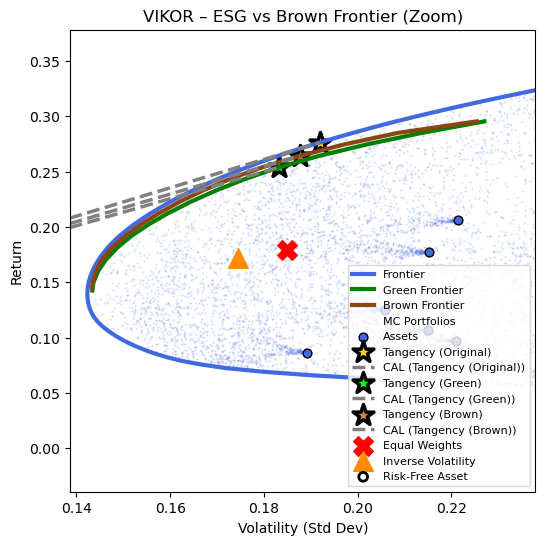

In [45]:
# ===================================================
# ZOOMED VIEW: ESG vs BROWN FRONTIERS AROUND TANGENCY
# ===================================================

margin = 0.03
pad_ratio = 0.25

for method, res in results.items():

    frontier_df = res["frontier"]
    frontier_esg_df = res["frontier_esg"]
    frontier_brown_df = res["frontier_brown"]

    port_df = res["portfolios"]
    bench = res.get("benchmarks", None)
    tan = res["tangency"]

    mu_sel = res["mu_sel"]
    df_return_sel = res["df_return_sel"]

    asset_returns = mu_sel.values
    asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

    # -------------------------------
    # Extract tangency values
    # -------------------------------
    if any(tan[k] is None for k in ["classical", "green", "brown"]):
        print(f"[{method}] Missing tangency → skipping zoom")
        continue

    tan_vol     = tan["classical"]["volatility"]
    tan_ret     = tan["classical"]["return"]
    tan_vol_esg = tan["green"]["volatility"]
    tan_ret_esg = tan["green"]["return"]
    tan_vol_b   = tan["brown"]["volatility"]
    tan_ret_b   = tan["brown"]["return"]

    # Classical frontier return column
    blue_ret_col = "achieved_return" if "achieved_return" in frontier_df.columns else "return"

    # -------------------------------
    # Local slices around tangencies
    # -------------------------------
    mask_blue = (
        (frontier_df["stdev"] >= tan_vol - margin) &
        (frontier_df["stdev"] <= tan_vol + margin)
    )

    mask_green = (
        (frontier_esg_df["stdev"] >= tan_vol_esg - margin) &
        (frontier_esg_df["stdev"] <= tan_vol_esg + margin)
    )

    mask_brown = (
        (frontier_brown_df["stdev"] >= tan_vol_b - margin) &
        (frontier_brown_df["stdev"] <= tan_vol_b + margin)
    )

    # -------------------------------
    # Compute zoom bounds from slices
    # -------------------------------
    x_min = min(
        frontier_df.loc[mask_blue, "stdev"].min(),
        frontier_esg_df.loc[mask_green, "stdev"].min(),
        frontier_brown_df.loc[mask_brown, "stdev"].min(),
        tan_vol, tan_vol_esg, tan_vol_b
    )

    x_max = max(
        frontier_df.loc[mask_blue, "stdev"].max(),
        frontier_esg_df.loc[mask_green, "stdev"].max(),
        frontier_brown_df.loc[mask_brown, "stdev"].max(),
        tan_vol, tan_vol_esg, tan_vol_b
    )

    y_min = min(
        frontier_df.loc[mask_blue, blue_ret_col].min(),
        frontier_esg_df.loc[mask_green, "achieved_return"].min(),
        frontier_brown_df.loc[mask_brown, "achieved_return"].min(),
        tan_ret, tan_ret_esg, tan_ret_b,
        rf
    )

    y_max = max(
        frontier_df.loc[mask_blue, blue_ret_col].max(),
        frontier_esg_df.loc[mask_green, "achieved_return"].max(),
        frontier_brown_df.loc[mask_brown, "achieved_return"].max(),
        tan_ret, tan_ret_esg, tan_ret_b
    )

    # Fallback if slices are empty
    if not np.isfinite(x_min) or not np.isfinite(x_max):
        x_min, x_max = min(tan_vol, tan_vol_esg, tan_vol_b), max(tan_vol, tan_vol_esg, tan_vol_b)
    if not np.isfinite(y_min) or not np.isfinite(y_max):
        y_min, y_max = min(tan_ret, tan_ret_esg, tan_ret_b, rf), max(tan_ret, tan_ret_esg, tan_ret_b)

    # -------------------------------
    # Padding
    # -------------------------------
    pad_x = pad_ratio * (x_max - x_min)
    pad_y = pad_ratio * (y_max - y_min)

    xlim_zoom = (x_min - pad_x, x_max + pad_x)
    ylim_zoom = (y_min - pad_y, y_max + pad_y)

    # -------------------------------
    # Plot configuration (same as old)
    # -------------------------------
    frontiers = [
        {
            "stdev": frontier_df["stdev"],
            "achieved_return": frontier_df[blue_ret_col],
            "color": "royalblue",
            "label": "Frontier"
        },
        {
            "stdev": frontier_esg_df["stdev"],
            "achieved_return": frontier_esg_df["achieved_return"],
            "color": "green",
            "label": "Green Frontier"
        },
        {
            "stdev": frontier_brown_df["stdev"],
            "achieved_return": frontier_brown_df["achieved_return"],
            "color": "saddlebrown",
            "label": "Brown Frontier"
        }
    ]

    tangencies = [
        {"vol": tan_vol,     "ret": tan_ret,     "color": "gold", "label": "Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color": "lime", "label": "Tangency (Green)"},
        {"vol": tan_vol_b,   "ret": tan_ret_b,   "color": "peru", "label": "Tangency (Brown)"}
    ]

    benchmarks = None
    if bench is not None:
        benchmarks = [
            {"vol": bench["EW"]["volatility"], "ret": bench["EW"]["return"],
             "color": "red", "marker": "X", "s": 200, "label": "Equal Weights"},
            {"vol": bench["IVW"]["volatility"], "ret": bench["IVW"]["return"],
             "color": "darkorange", "marker": "^", "s": 200, "label": "Inverse Volatility"}
        ]

    # -------------------------------
    # Plot zoomed comparison
    # -------------------------------
    plot_frontier(
        title=f"{method} – ESG vs Brown Frontier (Zoom)",
        filename=f"{method}_Frontier_ESG_Brown_Zoom.png",
        frontiers=frontiers,
        mc_df=port_df,
        asset_returns=asset_returns,
        asset_stdevs=asset_stdevs,
        rf=rf,
        tangencies=tangencies,
        benchmarks=benchmarks,
        xlim=xlim_zoom,
        ylim=ylim_zoom,
        figsize=(6, 6)
    )


In [46]:
def compute_metrics(returns, rf=0.00012 * 252):
    """
    returns: daily LOG returns (as produced by np.log(Pt/Pt-1))
    rf: annualized risk-free rate (consistent with annualized return/vol)
    """
    returns = pd.Series(returns).dropna()

    # consistent output columns
    out_keys = [
        "annual_return", "volatility", "sharpe", "sortino",
        "max_drawdown", "calmar", "ES_95", "rachev_95"
    ]
    if len(returns) < 2:
        return {k: np.nan for k in out_keys}

    ann_factor = 252

    # --- Annualized return (convert annualized log return -> annual simple return)
    ann_log_ret = returns.mean() * ann_factor
    annual_return = np.expm1(ann_log_ret)  # exp(ann_log_ret) - 1

    # --- Volatility (annualized)
    vol = returns.std(ddof=1) * np.sqrt(ann_factor)

    # --- Sharpe (annual)
    sharpe = (annual_return - rf) / vol if vol != 0 else np.nan

    # --- Sortino (annual)
    downside = returns[returns < 0]
    downside_std = downside.std(ddof=1) * np.sqrt(ann_factor)
    sortino = (annual_return - rf) / downside_std if downside_std != 0 else np.nan

    # --- Convert to SIMPLE daily returns for drawdown / tail metrics
    simple = np.expm1(returns)

    # Max drawdown (on simple returns)
    cum = (1 + simple).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = float(drawdown.min())
    calmar = annual_return / abs(max_dd) if max_dd != 0 else np.nan

    # --- ES (CVaR) 95% and Rachev ratio (on simple returns)
    alpha = 0.05
    var = simple.quantile(alpha)
    ES_95 = float(simple[simple <= var].mean())  # Expected Shortfall (mean tail loss)

    up_var = simple.quantile(1 - alpha)
    ES_up = float(simple[simple >= up_var].mean())

    rachev = ES_up / abs(ES_95) if ES_95 != 0 else np.nan

    return {
        "annual_return": float(annual_return),
        "volatility": float(vol),
        "sharpe": float(sharpe) if np.isfinite(sharpe) else np.nan,
        "sortino": float(sortino) if np.isfinite(sortino) else np.nan,
        "max_drawdown": max_dd,
        "calmar": float(calmar) if np.isfinite(calmar) else np.nan,
        "ES_95": ES_95,
        "rachev_95": float(rachev) if np.isfinite(rachev) else np.nan
    }

def portfolio_returns(weights, asset_returns_df):
    weights = np.array(weights).flatten()

    # asset_returns_df must be DataFrame with shape (n_days, n_assets)
    if asset_returns_df.shape[1] != len(weights):
        raise ValueError(
            f"Mismatch: asset_returns has {asset_returns_df.shape[1]} columns but weights length is {len(weights)}"
        )

    return asset_returns_df @ weights
    



In [47]:
rf = 0.00012 * 252

rows = []

for method, res in results.items():

    df_return_sel = res["df_return_sel"]
    tan = res["tangency"]

    for key, label in [
        ("classical", "Classical"),
        ("green", "Green"),
        ("brown", "Brown")
    ]:
        if tan[key] is None:
            continue

        weights = tan[key]["weights"]

        # Portfolio daily log returns
        ret_p = portfolio_returns(weights, df_return_sel)

        # Compute metrics
        metrics = compute_metrics(ret_p, rf=rf)

        rows.append({
            "Method": method,
            "Frontier": label,
            **metrics
        })


In [48]:
df_metrics = pd.DataFrame(rows)

# Optional: nicer ordering
df_metrics = df_metrics[
    ["Method", "Frontier",
     "annual_return", "volatility", "sharpe", "sortino",
     "max_drawdown", "calmar", "ES_95", "rachev_95"]
]

df_metrics


,Method,Frontier,annual_return,volatility,sharpe,sortino,max_drawdown,calmar,ES_95,rachev_95
0,AHP,Classical,0.323287,0.195730,1.497198,1.940358,-0.259200,1.247247,-0.027604,1.055347
1,AHP,Green,0.299038,0.192872,1.393659,1.737722,-0.308208,0.970248,-0.027657,1.000065
2,AHP,Brown,0.299038,0.187463,1.433876,1.790836,-0.274290,1.090228,-0.026809,1.012379
3,TOPSIS,Classical,0.348058,0.215745,1.473119,1.903448,-0.311263,1.118211,-0.030472,1.057863
4,TOPSIS,Green,0.299038,0.199265,1.348946,1.670655,-0.339347,0.881217,-0.028619,0.994979
5,TOPSIS,Brown,0.314738,0.205384,1.385205,1.709987,-0.332214,0.947395,-0.029528,0.997120
6,VIKOR,Classical,0.318167,0.191898,1.500411,1.943389,-0.250762,1.268800,-0.027239,1.043203
7,VIKOR,Green,0.288853,0.183153,1.412009,1.769592,-0.279258,1.034359,-0.026322,1.000483
8,VIKOR,Brown,0.302324,0.187671,1.449794,1.820099,-0.271791,1.112340,-0.026976,1.003761
